#### 1. fractured/non_fractured 폴더 내의 각 이미지 파일들을 신체 부위별로 분류하지 않고 한번에 학습

In [ ]:
import cv2, json, numpy as np, torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os

# 경로 
ROOT_IMG = Path("/home/a202152010/골절진단/data/images")
ANNO_JSON = Path("/home/a202152010/골절진단/data/Annotations/COCO JSON/COCO_fracture_masks.json")

SIZE     = (512, 512)
BATCH    = 4
EPOCHS   = 12
LR       = 1e-4
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA:", DEVICE)

CUDA: cuda


In [ ]:
class FractureSegDataset(Dataset):
    """ Fractured / Non_fractured 이미지 → (X, GT mask) """
    def __init__(self, split: str, coco: COCO, tf=None, with_mask=True):
        self.paths  = []                 # 이미지 경로
        self.labels = []                 # 1=fractured, 0=normal
        self.tf     = tf
        self.with_mask = with_mask
        # 이미지 탐색
        for cls, lab in [("Fractured",1), ("Non_fractured",0)]:
            for p in (ROOT_IMG/split/cls).glob("*.jpg"):
                self.paths.append(p); self.labels.append(lab)
        # COCO 내부 dict (file_name → anns)
        self.file2anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.file2anns.setdefault(fn, []).append(ann)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img_path, lab = self.paths[idx], self.labels[idx]
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h0, w0 = img.shape[:2]

        # 기본 마스크 (전부 0)
        mask = np.zeros((h0, w0), np.uint8)
        if lab == 1 and self.with_mask:          # fractured & mask 사용
            for ann in self.file2anns.get(img_path.name, []):
                for seg in ann["segmentation"]:
                    pts = np.array(seg).reshape(-1,2).astype(np.int32)
                    cv2.fillPoly(mask, [pts], 1)

        img  = cv2.resize(img,  SIZE)
        mask = cv2.resize(mask, SIZE, interpolation=cv2.INTER_NEAREST)

        if self.tf:
            aug = self.tf(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        return img, mask.unsqueeze(0).float()    # X:[3,H,W]  y:[1,H,W]


In [ ]:
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.HorizontalFlip(), A.RandomRotate90(),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
tf_val   = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

coco = COCO(str(ANNO_JSON))

train_dl = DataLoader(FractureSegDataset("train", coco, tf_train, with_mask=True),
                      batch_size=BATCH, shuffle=True,  num_workers=2)
val_dl   = DataLoader(FractureSegDataset("valid", coco, tf_val,   with_mask=True),
                      batch_size=BATCH, shuffle=False, num_workers=2)
test_dl  = DataLoader(FractureSegDataset("test",  coco, tf_val,   with_mask=False),
                      batch_size=1,     shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/tmp/ipykernel_4065222/2001014471.py:4: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.3),


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                 in_channels=3, classes=1, activation=None).to(DEVICE)

bce  = nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary")
def loss_fn(logits, mask):
    return bce(logits, mask) + dice(torch.sigmoid(logits), mask)

opt = optim.Adam(model.parameters(), lr=LR)

In [ ]:
def iou(pred, gt, thr=0.5, eps=1e-6):
    p = (pred>thr).float(); g = gt.float()
    inter = (p*g).sum(); union = p.sum()+g.sum()-inter
    return ((inter+eps)/(union+eps)).item()

for ep in range(1, EPOCHS+1):
    # Train
    model.train(); t_loss=0
    for X,y in train_dl:
        X,y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(); logit = model(X)
        loss = loss_fn(logit,y); loss.backward(); opt.step()
        t_loss += loss.item()
    # Val
    model.eval(); v_iou=v_dice=0; n=0
    with torch.no_grad():
        for X,y in val_dl:
            X,y = X.to(DEVICE), y.to(DEVICE)
            pr = torch.sigmoid(model(X))
            for b in range(X.size(0)):
                v_iou  += iou(pr[b,0], y[b,0])
                v_dice += dice(pr[b], y[b]).item(); n+=1
    print(f"Ep{ep:02d}  TrainLoss {t_loss/len(train_dl):.4f}  "
          f"Val IoU {v_iou/n:.4f}  Dice {1-v_dice/n:.4f}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep01  TrainLoss 0.7115  Val IoU 0.4332  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep02  TrainLoss 0.5589  Val IoU 0.6639  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep03  TrainLoss 0.5369  Val IoU 0.6754  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep04  TrainLoss 0.5272  Val IoU 0.8108  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep05  TrainLoss 0.5381  Val IoU 0.8124  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep06  TrainLoss 0.5427  Val IoU 0.7961  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep07  TrainLoss 0.5489  Val IoU 0.8238  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep08  TrainLoss 0.5372  Val IoU 0.8238  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep09  TrainLoss 0.5510  Val IoU 0.8244  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep10  TrainLoss 0.5227  Val IoU 0.8295  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep11  TrainLoss 0.5392  Val IoU 0.8288  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep12  TrainLoss 0.5306  Val IoU 0.8319  Dice 0.8255


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44264 (\N{HANGUL SYLLABLE GOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48744 (\N{HANGUL SYLLABLE BBAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPyt

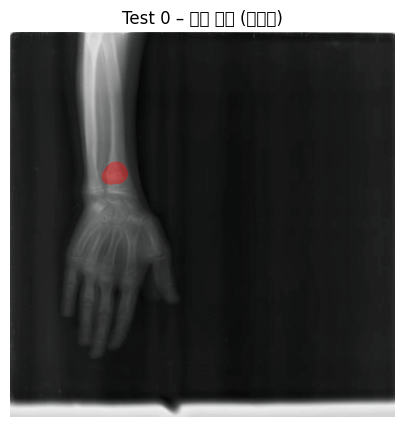

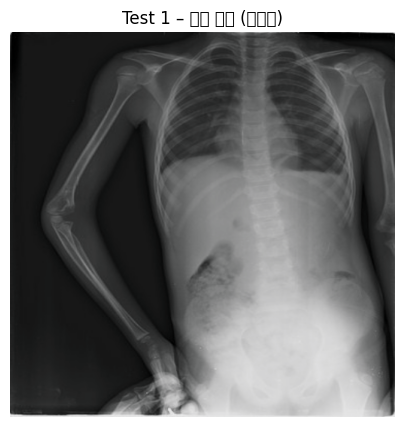

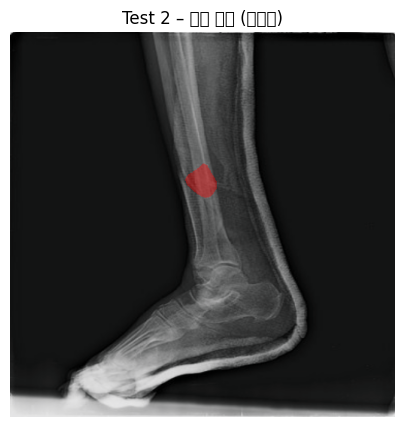

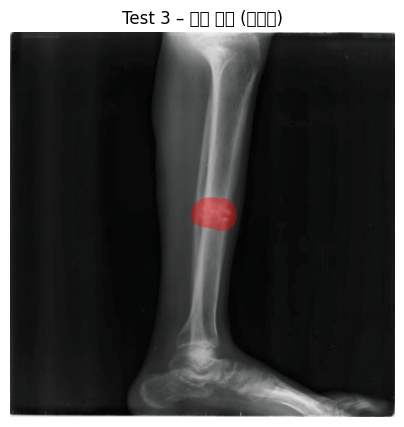

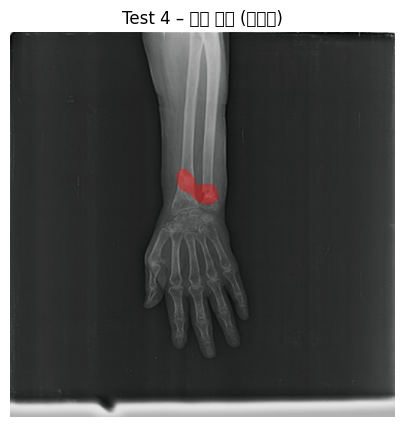

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


✅ 시각화 완료!  저장 위치: /home/a202152010/골절진단/visualization_results/test


In [ ]:
# Test 예측 마스크 시각화 & 저장 
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# 저장경로 지정 ─ 프로젝트 루트 기준
SAVE_DIR = Path("/home/a202152010/골절진단/visualization_results/test")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def overlay(img, mask, color=(255, 0, 0), alpha=0.4):
    """RGB img(H,W,3), mask(H,W) 0/1 → 빨간 오버레이"""
    h, w = img.shape[:2]
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    color_mask = np.zeros_like(img); color_mask[:] = color
    return np.where(mask[..., None], cv2.addWeighted(img, 1-alpha, color_mask, alpha, 0), img)

model.eval()
for idx, (X, _) in enumerate(test_dl):
    X = X.to(DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(model(X))[0, 0].cpu().numpy()
    pred = (prob > 0.5).astype(np.uint8)

    # 원본 픽셀로 복원 (Imagenet 역정규화)
    img = X[0].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
    img = (img * 255).astype(np.uint8)

    viz = overlay(img, pred)
    out_file = SAVE_DIR / f"test_{idx:04d}.png"
    cv2.imwrite(str(out_file), cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

    # 앞 5장은 바로 보여주기
    if idx < 5:
        plt.figure(figsize=(5,5))
        plt.imshow(viz); plt.axis('off')
        plt.title(f"Test {idx} – Fractured (red)")
        plt.show()

print(f"시각화 완료!  저장 위치: {SAVE_DIR.resolve()}")


In [ ]:
# ── Test 세트: 골절 이미지 분류 정확도 평가 ─────────────────
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np, torch, cv2, albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# 1. Test DataLoader는 앞서 만든 test_dl 그대로 사용
# 2. 임계값 설정
PROB_THRESH  = 0.5     # 픽셀을 1로 볼 확률 임계값
AREA_THRESH  = 0.001   # 전체 픽셀 대비 골절 픽셀 비율, 0.1% 이상이면 '골절'

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for (X, _), path_dict in zip(test_dl, test_dl.dataset.paths):
        # ─ 현재 배치는 1장이므로 X[0]
        X = X.to(DEVICE)
        prob = torch.sigmoid(model(X))[0, 0].cpu().numpy()      # [H,W]
        pred_mask = prob > PROB_THRESH
        frac_ratio = pred_mask.mean()                           # 골절 픽셀 비율
        pred_label = 1 if frac_ratio > AREA_THRESH else 0
        y_pred.append(pred_label)

        # ─ 폴더 이름으로 참값 라벨 얻기
        img_path = path_dict  # Dataset 클래스에서 저장해 둔 실제 경로
        true_label = 1 if "Fractured" in img_path.parts else 0
        y_true.append(true_label)

# 3. 성능 지표 출력
print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["normal","fracture"]))
print(f"Accuracy : {accuracy_score(y_true, y_pred):.3%}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


=== Confusion Matrix ===
[[503   2]
 [ 67  41]]

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.88      1.00      0.94       505
    fracture       0.95      0.38      0.54       108

    accuracy                           0.89       613
   macro avg       0.92      0.69      0.74       613
weighted avg       0.89      0.89      0.87       613

Accuracy : 88.744%


### U-Net 개선 
 - 실제 의료 진단에서는 골절 누락 방지가 더 중요함 -> 재현율 높이기 (증강, 골절 샘플 Oversampling, 임계값 낮춤)

In [ ]:
import cv2, json, torch, torch.nn as nn, torch.optim as optim
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

ROOT_IMG  = Path("/home/a202152010/골절진단/data/images")
ANNO_JSON = Path("/home/a202152010/골절진단/data/Annotations/COCO JSON/COCO_fracture_masks.json")

SIZE   = (512, 512)
BATCH  = 4
EPOCHS = 12
LR     = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA device:", DEVICE)

CUDA device: cuda


In [ ]:
class FractureSegDataset(Dataset):
    def __init__(self, split, coco: COCO, tf=None, with_mask=True):
        self.paths, self.labels = [], []           # 1=골절, 0=정상
        for cls, lab in [("Fractured",1), ("Non_fractured",0)]:
            for p in (ROOT_IMG/split/cls).glob("*.jpg"):
                self.paths.append(p)
                self.labels.append(lab)
        self.tf, self.with_mask = tf, with_mask
        self.file2anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.file2anns.setdefault(fn, []).append(ann)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p, lab = self.paths[idx], self.labels[idx]
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        h,w  = img.shape[:2]
        mask = np.zeros((h,w), np.uint8)

        if lab==1 and self.with_mask:              # 골절 이미지일 때만 마스크 생성
            for ann in self.file2anns.get(p.name, []):
                for seg in ann["segmentation"]:
                    pts = np.array(seg).reshape(-1,2).astype(np.int32)
                    cv2.fillPoly(mask, [pts], 1)

        img  = cv2.resize(img,  SIZE)
        mask = cv2.resize(mask, SIZE, interpolation=cv2.INTER_NEAREST)

        if self.tf:
            aug = self.tf(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        return img, mask.unsqueeze(0).float() 

In [ ]:
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.RandomGamma(gamma_limit=(80,120), p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(10.0,50.0), p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                       rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
tf_val = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

coco = COCO(str(ANNO_JSON))

train_ds = FractureSegDataset("train", coco, tf_train, with_mask=True)
val_ds   = FractureSegDataset("valid", coco, tf_val,   with_mask=True)
test_ds  = FractureSegDataset("test",  coco, tf_val,   with_mask=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/tmp/ipykernel_4065222/1946705008.py:9: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),


In [ ]:
# Oversampling 가중치 3배배
weights = [3 if l==1 else 1 for l in train_ds.labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=1,     shuffle=False)

print(f"Train {len(train_ds)} | Val {len(val_ds)} | Test {len(test_ds)}")

Train 2857 | Val 613 | Test 613


In [ ]:
from segmentation_models_pytorch.losses import FocalLoss
model = smp.Unet("resnet34", encoder_weights="imagenet",
                 in_channels=3, classes=1, activation=None).to(DEVICE)

bce   = nn.BCEWithLogitsLoss()
dice  = smp.losses.DiceLoss(mode="binary")
focal = FocalLoss(mode="binary", gamma=2.0)        # FN 패널티 강화

def loss_fn(logit, mask):
    prob = torch.sigmoid(logit)
    return 0.4*bce(logit, mask) + 0.4*dice(prob, mask) + 0.2*focal(prob, mask)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
def iou(pred, gt, thr=0.5, eps=1e-6):
    p = (pred>thr).float(); g = gt.float()
    inter = (p*g).sum(); union = p.sum()+g.sum()-inter
    return ((inter+eps)/(union+eps)).item()

for ep in range(1, EPOCHS+1):
    # --- Train
    model.train(); train_loss=0
    for X,y in train_dl:
        X,y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logit = model(X)
        loss = loss_fn(logit, y); loss.backward(); optimizer.step()
        train_loss += loss.item()

    # --- Val
    model.eval(); v_iou=v_dice=n=0
    with torch.no_grad():
        for X,y in val_dl:
            X,y = X.to(DEVICE), y.to(DEVICE)
            prob = torch.sigmoid(model(X))
            for b in range(X.size(0)):
                v_iou  += iou(prob[b,0], y[b,0])
                v_dice += dice(prob[b], y[b]).item()
                n += 1
    print(f"Ep{ep:02d}  TrainLoss {train_loss/len(train_dl):.4f}  "
          f"Val IoU {v_iou/n:.4f}  Dice {1-v_dice/n:.4f}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep01  TrainLoss 0.4939  Val IoU 0.7814  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep02  TrainLoss 0.3968  Val IoU 0.8238  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep03  TrainLoss 0.3807  Val IoU 0.8239  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep04  TrainLoss 0.3784  Val IoU 0.8024  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep05  TrainLoss 0.3792  Val IoU 0.7864  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep06  TrainLoss 0.3857  Val IoU 0.7680  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep07  TrainLoss 0.3847  Val IoU 0.7951  Dice 0.8257


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Ep08  TrainLoss 0.3805  Val IoU 0.8223  Dice 0.8257


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Ep09  TrainLoss 0.3846  Val IoU 0.8385  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep10  TrainLoss 0.3767  Val IoU 0.8294  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep11  TrainLoss 0.3782  Val IoU 0.8467  Dice 0.8257


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Ep12  TrainLoss 0.3780  Val IoU 0.7845  Dice 0.8258


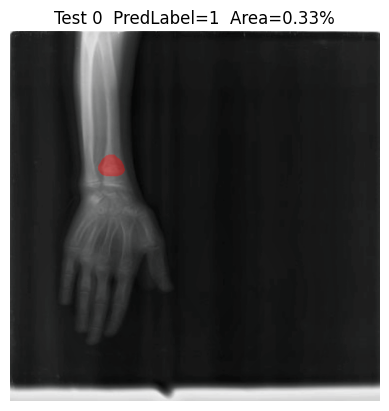

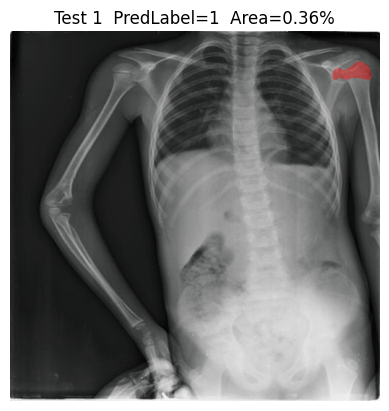

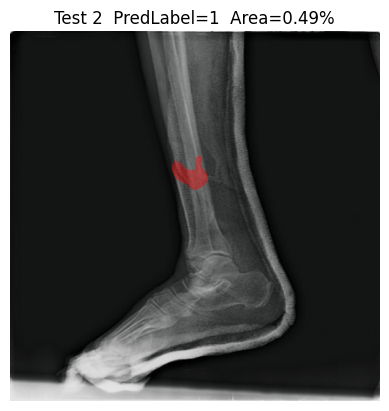

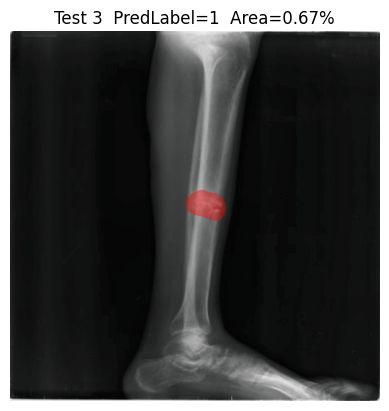

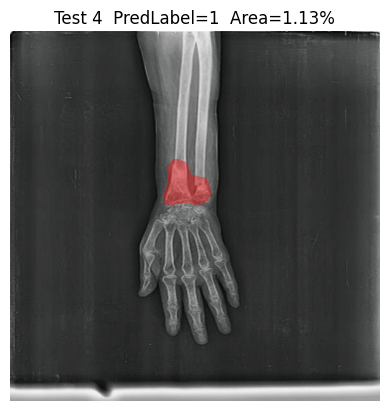

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


시각화 및 PNG 저장 완료: /home/a202152010/골절진단/visualization_results/unet_test


In [ ]:
SAVE_DIR = Path("/home/a202152010/골절진단/visualization_results/unet_test")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

PROB_THRESH = 0.4      # 낮춘 임계값
AREA_THRESH = 0.0005   # 0.05 %

def overlay(img, mask, color=(255,0,0), alpha=0.4):
    h,w = img.shape[:2]
    mask = cv2.resize(mask, (w,h), interpolation=cv2.INTER_NEAREST)
    clr  = np.zeros_like(img); clr[:] = color
    return np.where(mask[...,None], cv2.addWeighted(img,1-alpha,clr,alpha,0), img)

model.eval()
for idx, (X, _) in enumerate(test_dl):
    X = X.to(DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(model(X))[0,0].cpu().numpy()
    pred = prob > PROB_THRESH
    ratio = pred.mean()
    pred_label = 1 if ratio > AREA_THRESH else 0   # 1=골절로 분류

    # 원본 복원
    img = X[0].cpu().permute(1,2,0).numpy()
    img = np.clip(img*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
    img_uint8 = (img*255).astype(np.uint8)
    viz = overlay(img_uint8, pred.astype(np.uint8))
    cv2.imwrite(str(SAVE_DIR/f"unet_{idx:04d}_{pred_label}.png"),
                cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

    if idx < 5:              # 앞 5장은 노트북에 표시
        plt.imshow(viz); plt.axis('off')
        plt.title(f"Test {idx}  PredLabel={pred_label}  Area={ratio*100:.2f}%")
        plt.show()

print("시각화 및 PNG 저장 완료:", SAVE_DIR)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_true, y_pred = [], []
for p in SAVE_DIR.glob("unet_*.png"):
    # 파일명에 '_1.png' → Pred=1
    pred_label = 1 if p.stem.split('_')[-1]=='1' else 0
    if "Fractured" in p.name:    # 경로가 아니라 파일명만으로는 구분 어려우면 test_ds.paths 사용
        true_label = 1
    elif "Non_fractured" in p.name:
        true_label = 0
    else:
        # fallback: 이미 test_ds 순서대로 매핑
        idx = int(p.stem.split('_')[1])
        true_label = 1 if "Fractured" in test_ds.paths[idx].parts else 0
    y_pred.append(pred_label); y_true.append(true_label)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["normal","fracture"]))
print("Accuracy:", accuracy_score(y_true, y_pred))

=== Confusion Matrix ===
[[467  38]
 [ 27  81]]

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.95      0.92      0.93       505
    fracture       0.68      0.75      0.71       108

    accuracy                           0.89       613
   macro avg       0.81      0.84      0.82       613
weighted avg       0.90      0.89      0.90       613

Accuracy: 0.8939641109298532


# 신체 부위별 골절 진단 U-Net 모델
신체 부위별로 데이터를 분할하여 각각 전용 U-Net 모델을 훈련합니다.

## 데이터 분할 전략
1. CSV 파일에서 부위별 메타데이터 로드
2. 각 부위별로 이미지 필터링
3. 부위별 train/valid/test 분할
4. 부위별 모델 훈련 및 평가

In [ ]:
import pandas as pd
import cv2, json, numpy as np, torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

ROOT_IMG = Path("/home/a202152010/골절진단/data/images")
ANNO_JSON = Path("/home/a202152010/골절진단/data/Annotations/COCO JSON/COCO_fracture_masks.json")
CSV_PATH = Path("/home/a202152010/골절진단/data/dataset.csv")
RESULTS_DIR = Path("/home/a202152010/골절진단/bodypart_results")
RESULTS_DIR.mkdir(exist_ok=True)

# ── 하이퍼파라미터 ──
SIZE = (512, 512)
BATCH = 4
EPOCHS = 15
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🚀 Device: {DEVICE}")
print(f"📁 Results directory: {RESULTS_DIR}")

/home/a202152010/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/a202152010/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/a202152010/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


🚀 Device: cuda
📁 Results directory: /home/a202152010/골절진단/bodypart_results


In [ ]:
# 데이터셋 메타데이터 로드 및 분석
df = pd.read_csv(CSV_PATH)
print("=== 데이터셋 전체 통계 ===")
print(f"총 이미지 수: {len(df)}")
print(f"골절 이미지 수: {df['fractured'].sum()}")
print(f"정상 이미지 수: {(df['fractured']==0).sum()}")

print("\n=== 신체 부위별 분포 ===")
body_parts = ['hand', 'leg', 'hip', 'shoulder']
for part in body_parts:
    part_images = df[df[part] == 1]
    fractured_in_part = part_images[part_images['fractured'] == 1]
    print(f"{part.upper():>8}: 총 {len(part_images):4d}개 (골절 {len(fractured_in_part):3d}개, 정상 {len(part_images)-len(fractured_in_part):3d}개)")

print("\n=== Mixed 부위 확인 ===")
mixed_count = df['mixed'].sum()
print(f"Mixed 부위: {mixed_count}개")

# 각 이미지가 어떤 부위에 속하는지 확인
df['body_part'] = 'unknown'
for part in body_parts:
    df.loc[df[part] == 1, 'body_part'] = part

print(f"\n미분류 이미지 수: {(df['body_part'] == 'unknown').sum()}")

=== 데이터셋 전체 통계 ===
총 이미지 수: 4083
골절 이미지 수: 717
정상 이미지 수: 3366

=== 신체 부위별 분포 ===
    HAND: 총 1538개 (골절 438개, 정상 1100개)
     LEG: 총 2273개 (골절 263개, 정상 2010개)
     HIP: 총  338개 (골절  63개, 정상 275개)
SHOULDER: 총  349개 (골절  63개, 정상 286개)

=== Mixed 부위 확인 ===
Mixed 부위: 398개

미분류 이미지 수: 0


In [ ]:
class BodyPartFractureDataset(Dataset):
    """신체 부위별 골절 데이터셋"""
    def __init__(self, image_list, coco: COCO, split_type='train', tf=None, with_mask=True):
        self.image_list = image_list  # DataFrame의 subset
        self.split_type = split_type
        self.tf = tf
        self.with_mask = with_mask
        
        # COCO 어노테이션 매핑
        self.file2anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.file2anns.setdefault(fn, []).append(ann)
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        row = self.image_list.iloc[idx]
        img_name = row['image_id']
        is_fractured = row['fractured']
        
        # 이미지 파일 경로 찾기
        img_path = None
        for split_dir in ['train', 'valid', 'test']:
            for class_dir in ['Fractured', 'Non_fractured']:
                potential_path = ROOT_IMG / split_dir / class_dir / img_name
                if potential_path.exists():
                    img_path = potential_path
                    break
            if img_path:
                break
        
        if not img_path or not img_path.exists():
            raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {img_name}")
        
        # 이미지 로드
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # 마스크 생성
        mask = np.zeros((h, w), np.uint8)
        if is_fractured and self.with_mask:
            for ann in self.file2anns.get(img_name, []):
                for seg in ann["segmentation"]:
                    pts = np.array(seg).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [pts], 1)
        
        # 리사이즈
        img = cv2.resize(img, SIZE)
        mask = cv2.resize(mask, SIZE, interpolation=cv2.INTER_NEAREST)
        
        # 데이터 증강
        if self.tf:
            aug = self.tf(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]
        
        return img, mask.unsqueeze(0).float()

print("BodyPartFractureDataset 클래스 정의 완료")

✅ BodyPartFractureDataset 클래스 정의 완료


In [ ]:
def create_bodypart_splits(df, body_part, test_size=0.2, val_size=0.2, random_state=42):
    """특정 신체 부위의 데이터를 train/valid/test로 분할"""
    
    # 해당 부위 데이터만 필터링
    part_data = df[df[body_part] == 1].copy()
    
    if len(part_data) == 0:
        print(f"{body_part} 부위 데이터가 없습니다.")
        return None, None, None
    
    print(f"\n=== {body_part.upper()} 부위 데이터 분할 ===")
    print(f"전체 {body_part} 이미지: {len(part_data)}개")
    
    # 골절/정상별 분할
    fractured = part_data[part_data['fractured'] == 1]
    normal = part_data[part_data['fractured'] == 0]
    
    print(f"골절: {len(fractured)}개, 정상: {len(normal)}개")
    
    # 각각 train/val/test 분할
    def split_data(data, test_size, val_size):
        if len(data) < 3:  # 최소 3개는 있어야 분할 가능
            return data, pd.DataFrame(), pd.DataFrame()
        
        # 먼저 train+val과 test 분할
        train_val, test = train_test_split(data, test_size=test_size, random_state=random_state)
        
        if len(train_val) < 2:
            return train_val, pd.DataFrame(), test
        
        # train과 val 분할
        val_size_adjusted = val_size / (1 - test_size)  # 남은 데이터에서의 비율 조정
        train, val = train_test_split(train_val, test_size=val_size_adjusted, random_state=random_state)
        
        return train, val, test
    
    # 골절 데이터 분할
    if len(fractured) > 0:
        frac_train, frac_val, frac_test = split_data(fractured, test_size, val_size)
    else:
        frac_train = frac_val = frac_test = pd.DataFrame()
    
    # 정상 데이터 분할
    if len(normal) > 0:
        norm_train, norm_val, norm_test = split_data(normal, test_size, val_size)
    else:
        norm_train = norm_val = norm_test = pd.DataFrame()
    
    # 합치기
    train_data = pd.concat([frac_train, norm_train], ignore_index=True)
    val_data = pd.concat([frac_val, norm_val], ignore_index=True)
    test_data = pd.concat([frac_test, norm_test], ignore_index=True)
    
    print(f"분할 결과:")
    print(f"  Train: {len(train_data)}개 (골절: {(train_data['fractured']==1).sum()}개)")
    print(f"  Valid: {len(val_data)}개 (골절: {(val_data['fractured']==1).sum()}개)")
    print(f"  Test:  {len(test_data)}개 (골절: {(test_data['fractured']==1).sum()}개)")
    
    return train_data, val_data, test_data

print(" 데이터 분할 함수 정의 완료")

✅ 데이터 분할 함수 정의 완료


In [ ]:
# 데이터 증강 설정
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.RandomGamma(gamma_limit=(80,120), p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(10.0,50.0), p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                       rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

tf_val = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# COCO 데이터 로드
coco = COCO(str(ANNO_JSON))
print("COCO 어노테이션 로드 완료")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
✅ COCO 어노테이션 로드 완료


In [ ]:
def train_bodypart_model(body_part, train_data, val_data, test_data):
    """특정 신체 부위에 대한 U-Net 모델 훈련"""
    
    print(f"\n{body_part.upper()} 부위 모델 훈련 시작")
    
    # 데이터셋 생성
    train_ds = BodyPartFractureDataset(train_data, coco, 'train', tf_train, True)
    val_ds = BodyPartFractureDataset(val_data, coco, 'val', tf_val, True)
    test_ds = BodyPartFractureDataset(test_data, coco, 'test', tf_val, False)
    
    # Oversampling (골절 데이터 3배 가중치)
    weights = [3 if row['fractured']==1 else 1 for _, row in train_data.iterrows()]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    
    # 데이터로더
    train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)
    
    # 모델 초기화
    model = smp.Unet("resnet34", encoder_weights="imagenet",
                     in_channels=3, classes=1, activation=None).to(DEVICE)
    
    # 손실 함수 (FocalLoss 추가로 FN 패널티 강화)
    bce = nn.BCEWithLogitsLoss()
    dice = smp.losses.DiceLoss(mode="binary")
    focal = smp.losses.FocalLoss(mode="binary", gamma=2.0)
    
    def loss_fn(logit, mask):
        prob = torch.sigmoid(logit)
        return 0.4*bce(logit, mask) + 0.4*dice(prob, mask) + 0.2*focal(prob, mask)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # IoU 계산 함수
    def iou(pred, gt, thr=0.5, eps=1e-6):
        p = (pred>thr).float(); g = gt.float()
        inter = (p*g).sum(); union = p.sum()+g.sum()-inter
        return ((inter+eps)/(union+eps)).item()
    
    # 훈련 루프
    best_val_iou = 0
    train_losses, val_ious, val_dices = [], [], []
    
    for ep in range(1, EPOCHS+1):
        # --- Train
        model.train()
        train_loss = 0
        for X, y in train_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logit = model(X)
            loss = loss_fn(logit, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # --- Validation
        model.eval()
        v_iou = v_dice = n = 0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(DEVICE), y.to(DEVICE)
                prob = torch.sigmoid(model(X))
                for b in range(X.size(0)):
                    v_iou += iou(prob[b,0], y[b,0])
                    v_dice += dice(prob[b], y[b]).item()
                    n += 1
        
        avg_train_loss = train_loss / len(train_dl)
        avg_val_iou = v_iou / n if n > 0 else 0
        avg_val_dice = 1 - v_dice / n if n > 0 else 0
        
        train_losses.append(avg_train_loss)
        val_ious.append(avg_val_iou)
        val_dices.append(avg_val_dice)
        
        print(f"Epoch {ep:02d}: Loss {avg_train_loss:.4f}, Val IoU {avg_val_iou:.4f}, Val Dice {avg_val_dice:.4f}")
        
        # 베스트 모델 저장
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), RESULTS_DIR / f"best_{body_part}_unet.pth")
    
    return model, train_losses, val_ious, val_dices, test_dl

print("✅ 부위별 모델 훈련 함수 정의 완료")

✅ 부위별 모델 훈련 함수 정의 완료


In [ ]:
def evaluate_bodypart_model(model, test_dl, body_part, prob_thresh=0.4, area_thresh=0.0005):
    """부위별 모델 평가 및 시각화"""
    
    print(f"\n{body_part.upper()} 모델 평가 중...")
    
    # 시각화 저장 경로
    viz_dir = RESULTS_DIR / f"{body_part}_visualizations"
    viz_dir.mkdir(exist_ok=True)
    
    def overlay(img, mask, color=(255,0,0), alpha=0.4):
        h, w = img.shape[:2]
        mask = cv2.resize(mask, (w,h), interpolation=cv2.INTER_NEAREST)
        clr = np.zeros_like(img); clr[:] = color
        return np.where(mask[...,None], cv2.addWeighted(img,1-alpha,clr,alpha,0), img)
    
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for idx, (X, _) in enumerate(test_dl):
            X = X.to(DEVICE)
            prob = torch.sigmoid(model(X))[0,0].cpu().numpy()
            pred_mask = prob > prob_thresh
            ratio = pred_mask.mean()
            pred_label = 1 if ratio > area_thresh else 0
            
            # Ground truth 라벨 (데이터 경로에서 추출)
            test_img_info = test_dl.dataset.image_list.iloc[idx]
            true_label = test_img_info['fractured']
            
            y_pred.append(pred_label)
            y_true.append(true_label)
            
            # 시각화
            img = X[0].cpu().permute(1,2,0).numpy()
            img = np.clip(img*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
            img_uint8 = (img*255).astype(np.uint8)
            viz = overlay(img_uint8, pred_mask.astype(np.uint8))
            
            # 저장
            img_name = test_img_info['image_id']
            cv2.imwrite(str(viz_dir / f"{body_part}_{idx:03d}_{img_name}"),
                       cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))
            
            # 처음 3개 이미지 표시
            if idx < 3:
                plt.figure(figsize=(8,6))
                plt.imshow(viz)
                plt.axis('off')
                plt.title(f"{body_part.upper()} Test {idx}: True={true_label}, Pred={pred_label}\n"
                         f"Fracture Area: {ratio*100:.2f}%")
                plt.show()
    
    # 성능 평가
    print(f"\n=== {body_part.upper()} 모델 성능 ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fractured"]))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3%}")
    
    return y_true, y_pred

print("부위별 모델 평가 함수 정의 완료")

✅ 부위별 모델 평가 함수 정의 완료



🏥 HAND 부위 처리 시작

=== HAND 부위 데이터 분할 ===
전체 hand 이미지: 1538개
골절: 438개, 정상: 1100개
분할 결과:
  Train: 922개 (골절: 262개)
  Valid: 308개 (골절: 88개)
  Test:  308개 (골절: 88개)

🚀 HAND 부위 모델 훈련 시작


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 01: Loss 0.7067, Val IoU 0.0000, Val Dice 0.7164


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 02: Loss 0.5333, Val IoU 0.4708, Val Dice 0.7163


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 03: Loss 0.4893, Val IoU 0.5487, Val Dice 0.7163


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 04: Loss 0.4593, Val IoU 0.4416, Val Dice 0.7163


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.4446, Val IoU 0.6883, Val Dice 0.7164


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 06: Loss 0.4432, Val IoU 0.6786, Val Dice 0.7164


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 07: Loss 0.4383, Val IoU 0.4581, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 08: Loss 0.4386, Val IoU 0.6043, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 09: Loss 0.4312, Val IoU 0.6033, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 10: Loss 0.4228, Val IoU 0.6171, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 11: Loss 0.4148, Val IoU 0.6971, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 12: Loss 0.4260, Val IoU 0.6254, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 13: Loss 0.4150, Val IoU 0.7133, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 14: Loss 0.4229, Val IoU 0.7424, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 15: Loss 0.4173, Val IoU 0.4632, Val Dice 0.7166

📊 HAND 모델 평가 중...


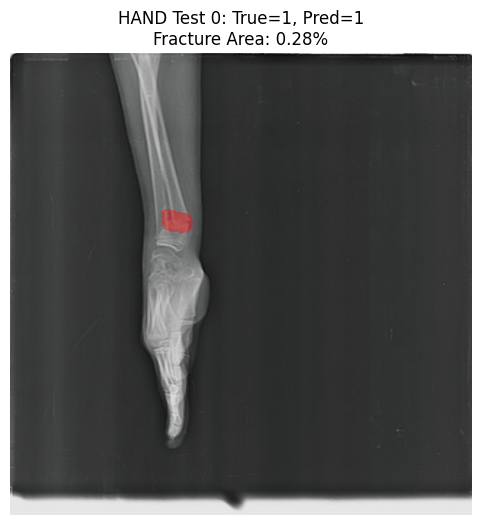

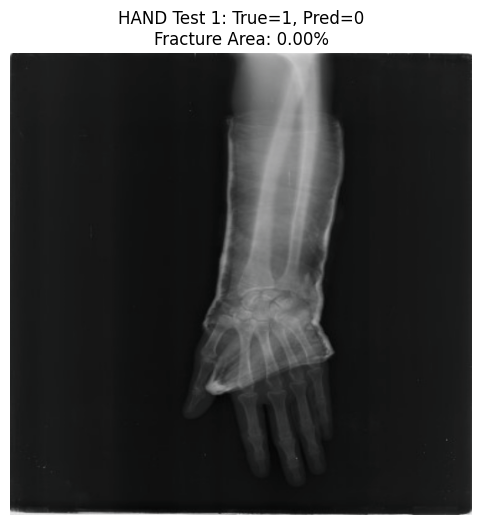

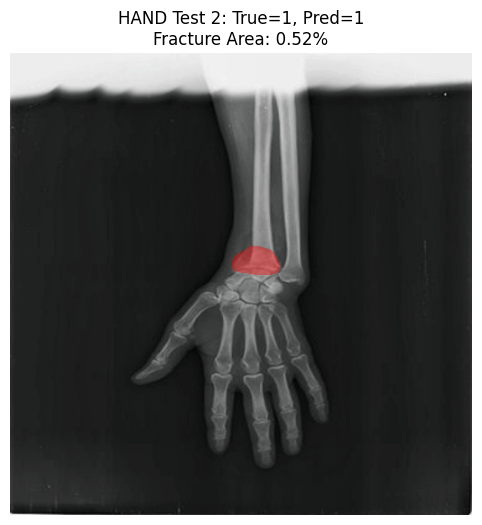

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



=== HAND 모델 성능 ===
Confusion Matrix:
[[206  14]
 [ 33  55]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.94      0.90       220
   Fractured       0.80      0.62      0.70        88

    accuracy                           0.85       308
   macro avg       0.83      0.78      0.80       308
weighted avg       0.84      0.85      0.84       308

Accuracy: 84.740%


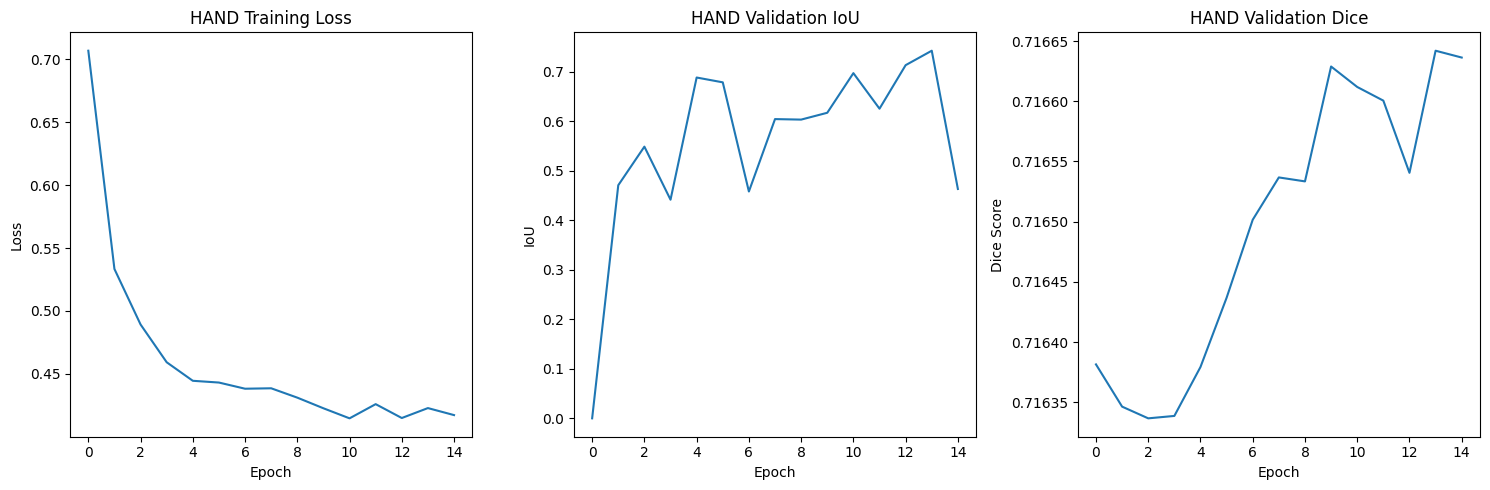

✅ HAND 부위 처리 완료!

🏥 LEG 부위 처리 시작

=== LEG 부위 데이터 분할 ===
전체 leg 이미지: 2273개
골절: 263개, 정상: 2010개
분할 결과:
  Train: 1363개 (골절: 157개)
  Valid: 455개 (골절: 53개)
  Test:  455개 (골절: 53개)

🚀 LEG 부위 모델 훈련 시작


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 01: Loss 0.3558, Val IoU 0.8835, Val Dice 0.8851


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 02: Loss 0.3312, Val IoU 0.8835, Val Dice 0.8851


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 03: Loss 0.3334, Val IoU 0.8594, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 04: Loss 0.3256, Val IoU 0.8899, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.3406, Val IoU 0.8952, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 06: Loss 0.3201, Val IoU 0.9006, Val Dice 0.8852


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 07: Loss 0.3338, Val IoU 0.8516, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 08: Loss 0.3312, Val IoU 0.8928, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 09: Loss 0.3274, Val IoU 0.8760, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 10: Loss 0.3340, Val IoU 0.9004, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 11: Loss 0.3149, Val IoU 0.9010, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 12: Loss 0.3372, Val IoU 0.8913, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 13: Loss 0.3338, Val IoU 0.9015, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 14: Loss 0.3371, Val IoU 0.9015, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 15: Loss 0.3217, Val IoU 0.9153, Val Dice 0.8853

📊 LEG 모델 평가 중...


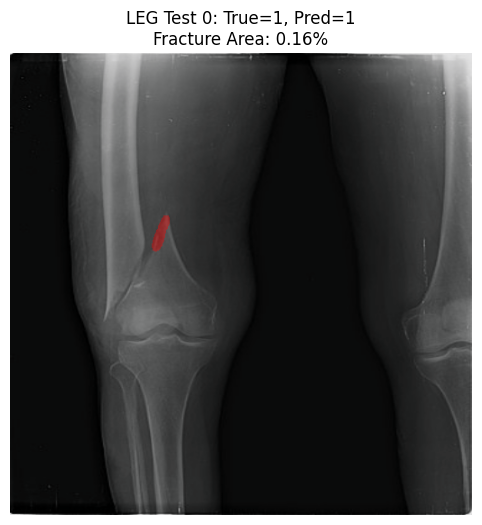

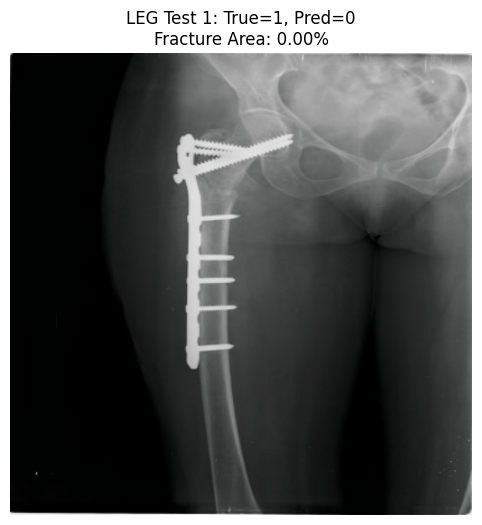

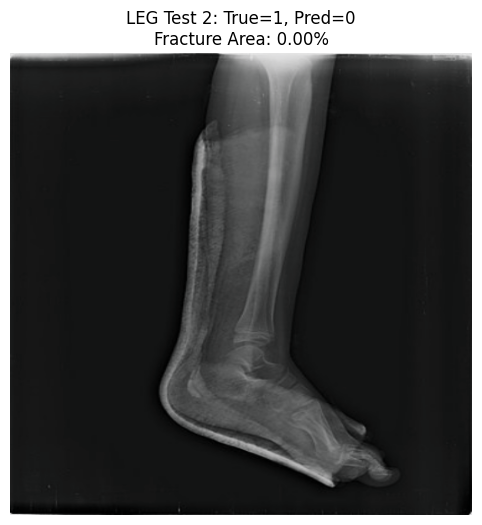

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



=== LEG 모델 성능 ===
Confusion Matrix:
[[400   2]
 [ 26  27]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       402
   Fractured       0.93      0.51      0.66        53

    accuracy                           0.94       455
   macro avg       0.94      0.75      0.81       455
weighted avg       0.94      0.94      0.93       455

Accuracy: 93.846%


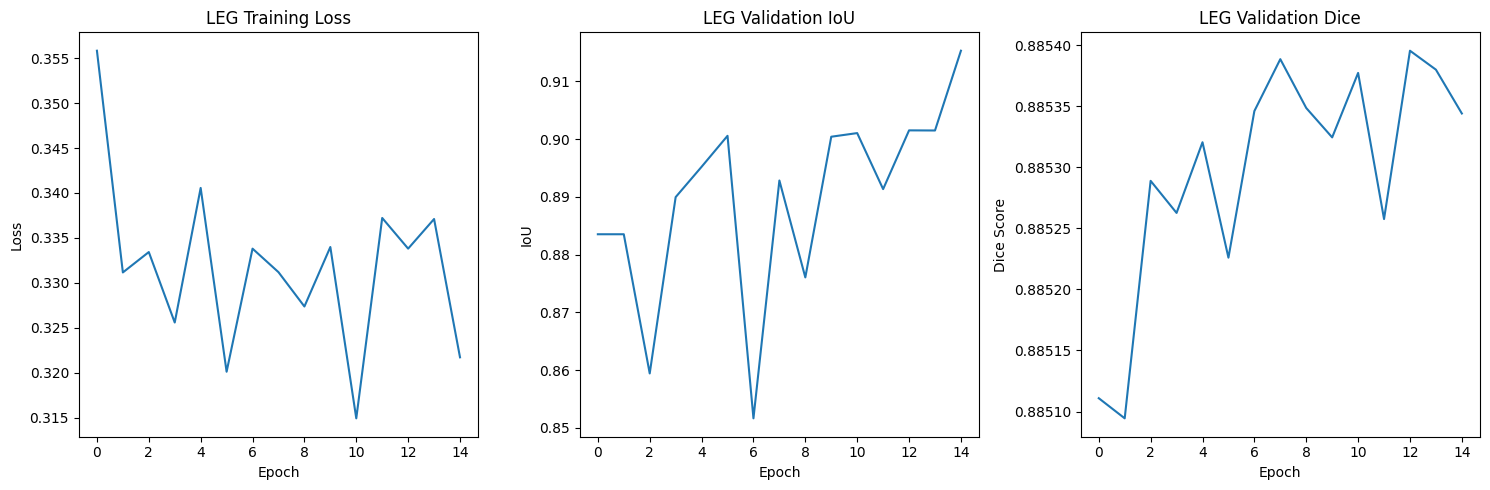

✅ LEG 부위 처리 완료!

🏥 HIP 부위 처리 시작

=== HIP 부위 데이터 분할 ===
전체 hip 이미지: 338개
골절: 63개, 정상: 275개
분할 결과:
  Train: 202개 (골절: 37개)
  Valid: 68개 (골절: 13개)
  Test:  68개 (골절: 13개)

🚀 HIP 부위 모델 훈련 시작
Epoch 01: Loss 0.5969, Val IoU 0.0002, Val Dice 0.8133
Epoch 02: Loss 0.4864, Val IoU 0.7353, Val Dice 0.8133
Epoch 03: Loss 0.4384, Val IoU 0.8088, Val Dice 0.8133
Epoch 04: Loss 0.4765, Val IoU 0.7941, Val Dice 0.8133


Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.4161, Val IoU 0.7500, Val Dice 0.8133
Epoch 06: Loss 0.4199, Val IoU 0.7941, Val Dice 0.8133
Epoch 07: Loss 0.4273, Val IoU 0.7353, Val Dice 0.8133


Premature end of JPEG file


Epoch 08: Loss 0.4289, Val IoU 0.8088, Val Dice 0.8133
Epoch 09: Loss 0.3846, Val IoU 0.8088, Val Dice 0.8134
Epoch 10: Loss 0.3882, Val IoU 0.7794, Val Dice 0.8135


Premature end of JPEG file


Epoch 11: Loss 0.4160, Val IoU 0.8088, Val Dice 0.8134


Premature end of JPEG file


Epoch 12: Loss 0.4134, Val IoU 0.8088, Val Dice 0.8133


Premature end of JPEG file


Epoch 13: Loss 0.4114, Val IoU 0.8088, Val Dice 0.8136
Epoch 14: Loss 0.3777, Val IoU 0.8088, Val Dice 0.8136


Premature end of JPEG file


Epoch 15: Loss 0.4156, Val IoU 0.8088, Val Dice 0.8137

📊 HIP 모델 평가 중...


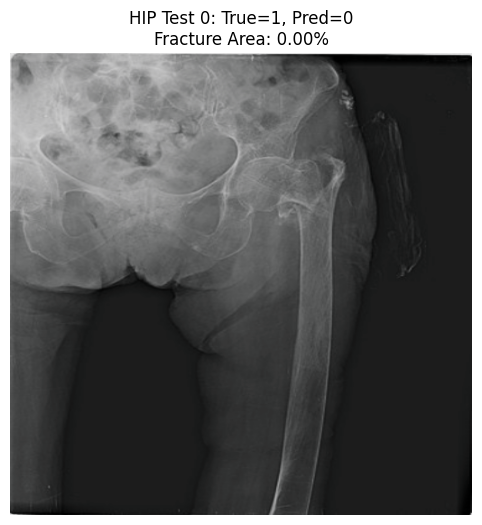

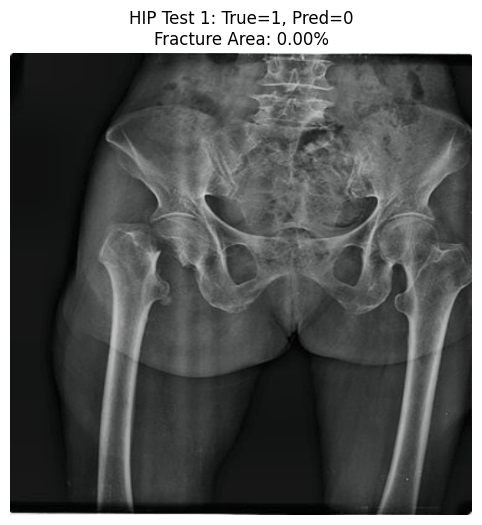

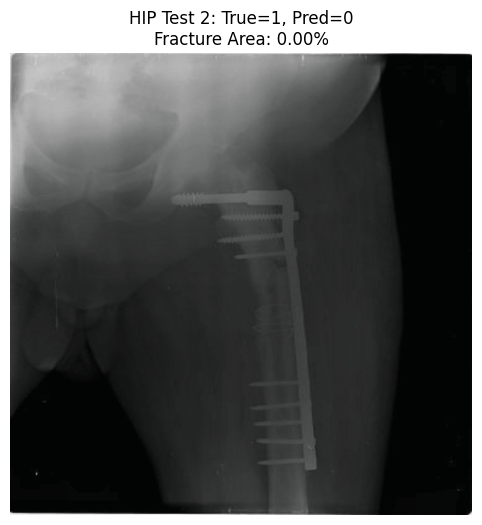


=== HIP 모델 성능 ===
Confusion Matrix:
[[55  0]
 [13  0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.81      1.00      0.89        55
   Fractured       0.00      0.00      0.00        13

    accuracy                           0.81        68
   macro avg       0.40      0.50      0.45        68
weighted avg       0.65      0.81      0.72        68

Accuracy: 80.882%


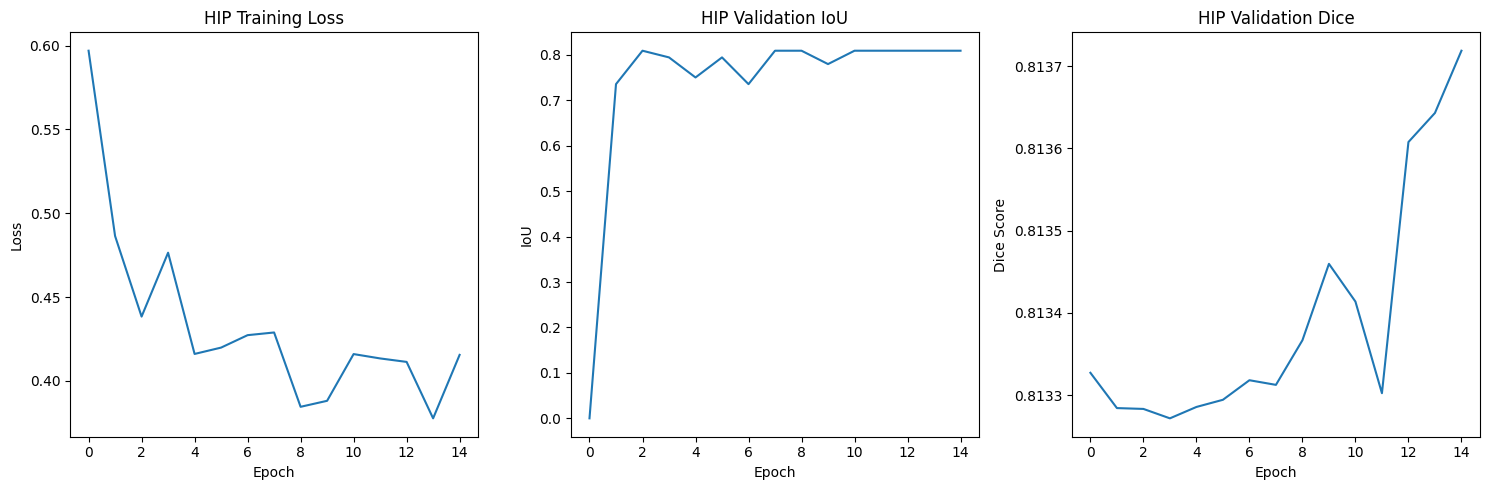

✅ HIP 부위 처리 완료!

🏥 SHOULDER 부위 처리 시작

=== SHOULDER 부위 데이터 분할 ===
전체 shoulder 이미지: 349개
골절: 63개, 정상: 286개
분할 결과:
  Train: 208개 (골절: 37개)
  Valid: 70개 (골절: 13개)
  Test:  71개 (골절: 13개)

🚀 SHOULDER 부위 모델 훈련 시작


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 01: Loss 0.5438, Val IoU 0.0001, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 02: Loss 0.4596, Val IoU 0.0429, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 03: Loss 0.4370, Val IoU 0.1143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 04: Loss 0.4482, Val IoU 0.1714, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.4253, Val IoU 0.4857, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 06: Loss 0.4196, Val IoU 0.6143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 07: Loss 0.4229, Val IoU 0.6571, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 08: Loss 0.4116, Val IoU 0.4143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 09: Loss 0.3934, Val IoU 0.7286, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 10: Loss 0.3833, Val IoU 0.5714, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file


Epoch 11: Loss 0.4045, Val IoU 0.8143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file


Epoch 12: Loss 0.3951, Val IoU 0.8143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 13: Loss 0.4321, Val IoU 0.7714, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 14: Loss 0.3924, Val IoU 0.7857, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 15: Loss 0.3990, Val IoU 0.8000, Val Dice 0.8156

📊 SHOULDER 모델 평가 중...


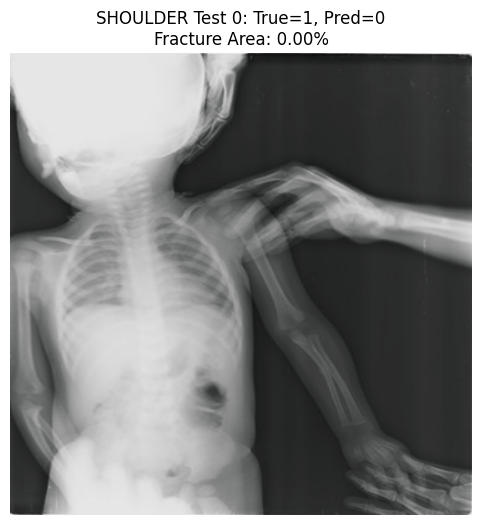

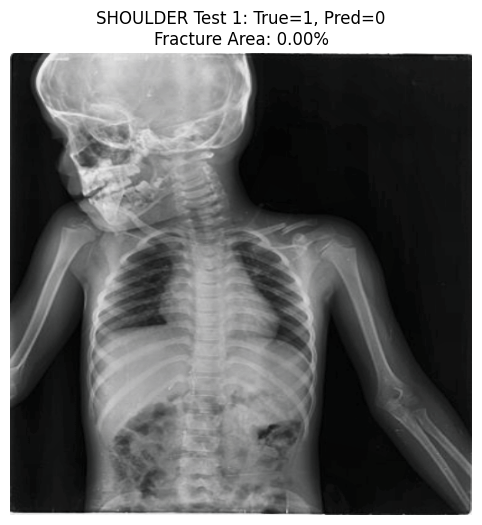

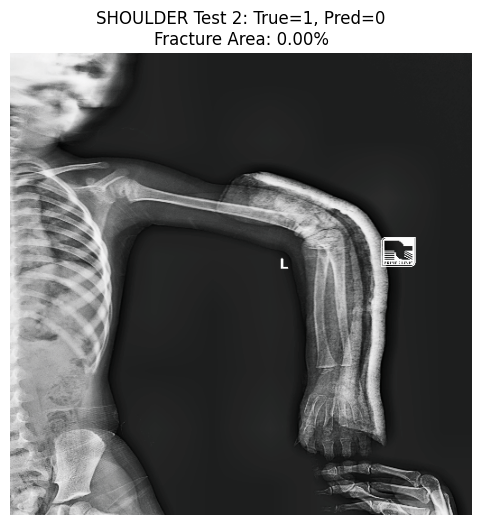

Premature end of JPEG file



=== SHOULDER 모델 성능 ===
Confusion Matrix:
[[58  0]
 [13  0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90        58
   Fractured       0.00      0.00      0.00        13

    accuracy                           0.82        71
   macro avg       0.41      0.50      0.45        71
weighted avg       0.67      0.82      0.73        71

Accuracy: 81.690%


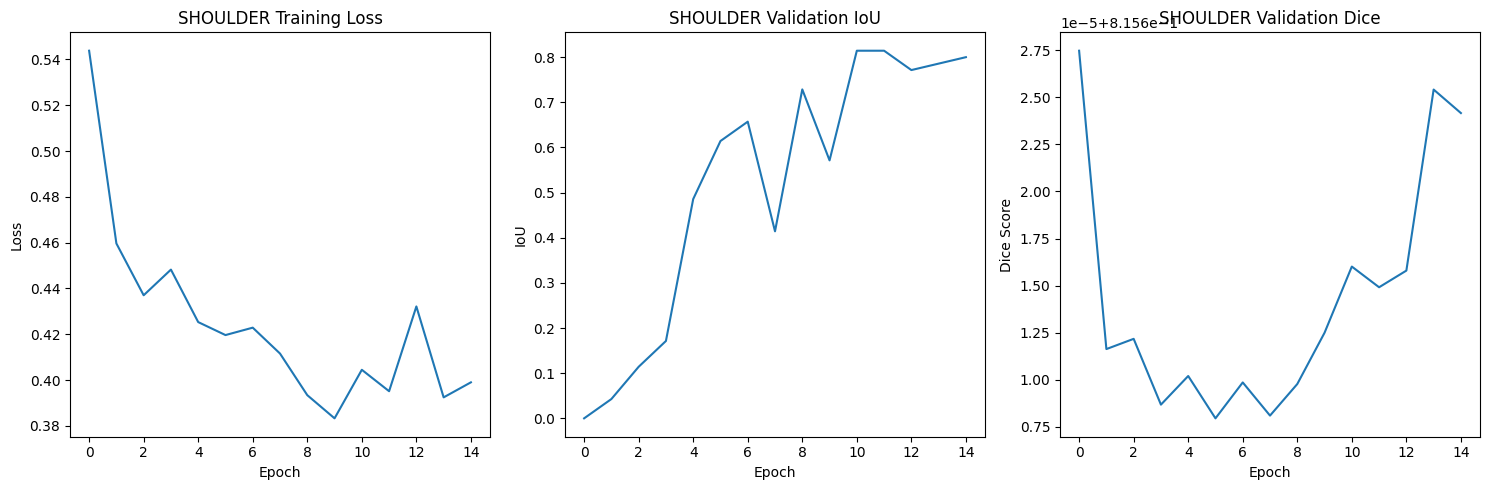

✅ SHOULDER 부위 처리 완료!

🎉 모든 부위별 모델 훈련 완료!


In [ ]:
# 메인 실행: 각 신체 부위별 모델 훈련 및 평가

body_parts = ['hand', 'leg', 'hip', 'shoulder']
results_summary = {}

for body_part in body_parts:
    try:
        print(f"\n{'='*50}")
        print(f"🏥 {body_part.upper()} 부위 처리 시작")
        print(f"{'='*50}")
        
        # 1. 데이터 분할
        train_data, val_data, test_data = create_bodypart_splits(df, body_part)
        
        if train_data is None or len(train_data) < 5:
            print(f"{body_part} 부위의 데이터가 부족합니다. 건너뜁니다.")
            continue
        
        # 2. 모델 훈련
        model, train_losses, val_ious, val_dices, test_dl = train_bodypart_model(
            body_part, train_data, val_data, test_data
        )
        
        # 3. 베스트 모델 로드 및 평가
        model.load_state_dict(torch.load(RESULTS_DIR / f"best_{body_part}_unet.pth"))
        y_true, y_pred = evaluate_bodypart_model(model, test_dl, body_part)
        
        # 4. 결과 저장
        results_summary[body_part] = {
            'accuracy': accuracy_score(y_true, y_pred),
            'train_samples': len(train_data),
            'val_samples': len(val_data),
            'test_samples': len(test_data),
            'best_val_iou': max(val_ious) if val_ious else 0,
            'best_val_dice': max(val_dices) if val_dices else 0
        }
        
        # 5. 훈련 곡선 저장
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(train_losses)
        plt.title(f'{body_part.upper()} Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 3, 2)
        plt.plot(val_ious)
        plt.title(f'{body_part.upper()} Validation IoU')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        
        plt.subplot(1, 3, 3)
        plt.plot(val_dices)
        plt.title(f'{body_part.upper()} Validation Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f'{body_part}_training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ {body_part.upper()} 부위 처리 완료!")
        
    except Exception as e:
        print(f"{body_part} 처리 중 오류 발생: {e}")
        continue

print(f"\n모든 부위별 모델 훈련 완료!")


🏆 신체 부위별 모델 성능 요약
          accuracy  train_samples  val_samples  test_samples  best_val_iou  \
hand        0.8474          922.0        308.0         308.0        0.7424   
leg         0.9385         1363.0        455.0         455.0        0.9153   
hip         0.8088          202.0         68.0          68.0        0.8088   
shoulder    0.8169          208.0         70.0          71.0        0.8143   

          best_val_dice  
hand             0.7166  
leg              0.8854  
hip              0.8137  
shoulder         0.8156  


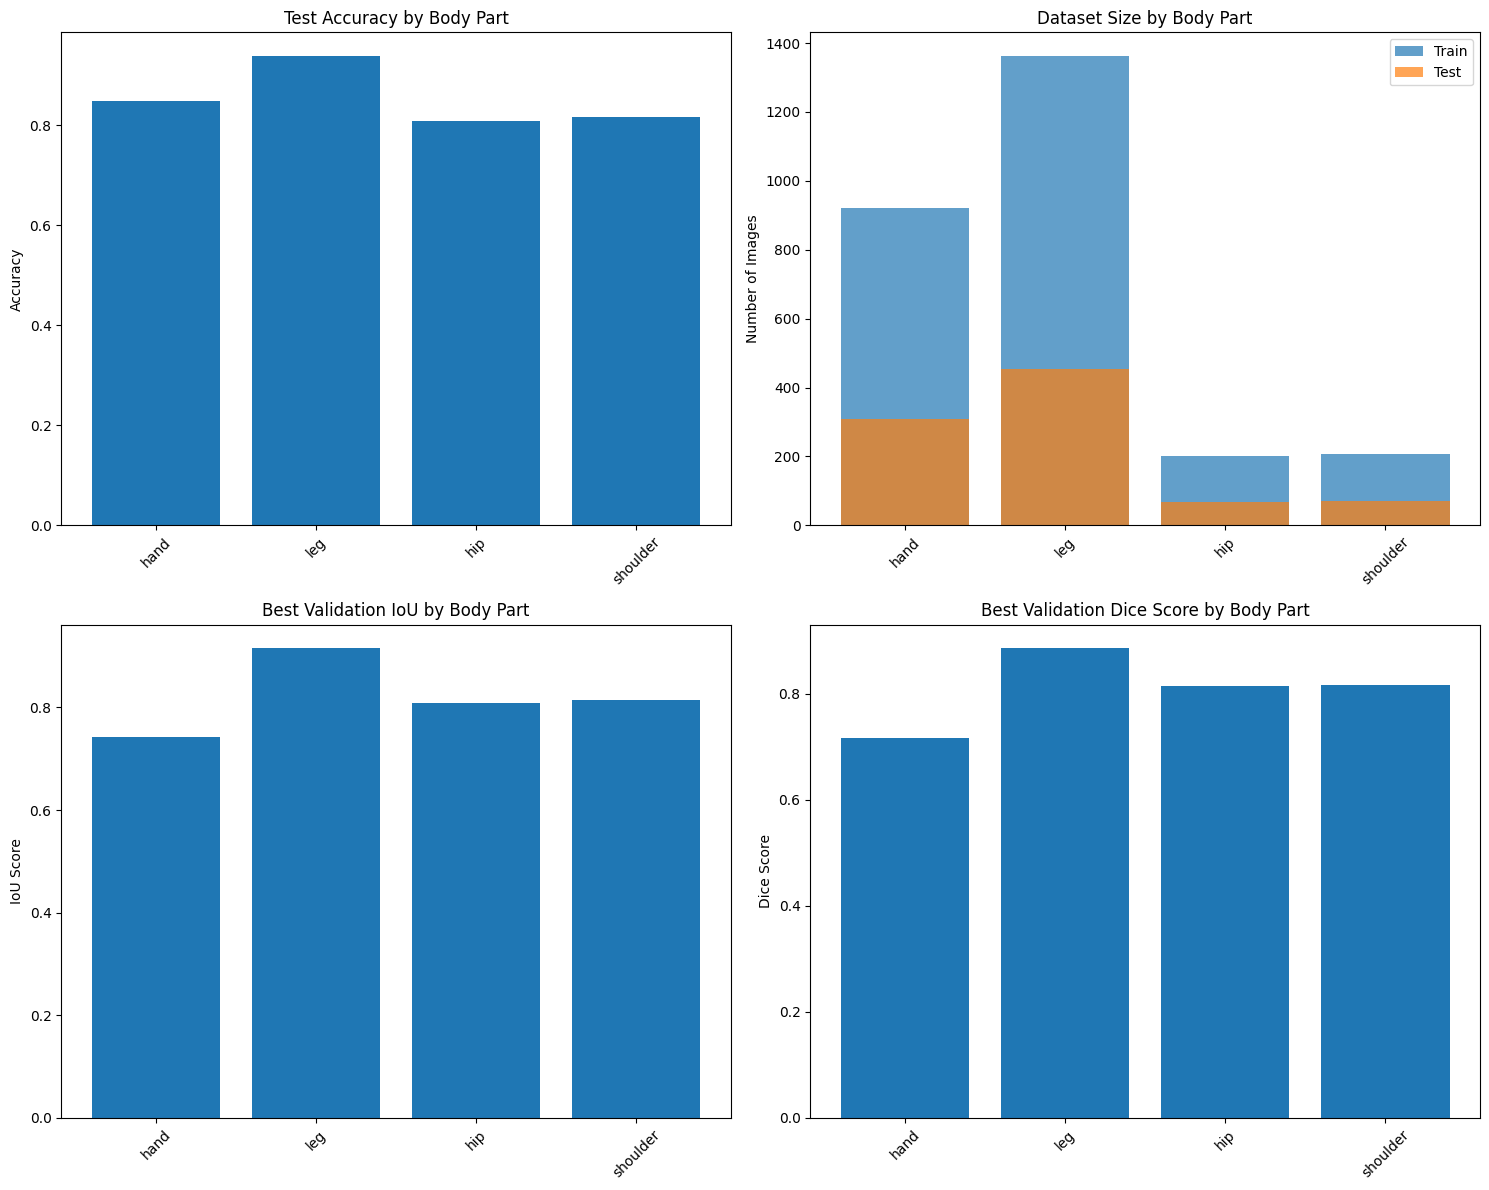


🥇 최고 성능:
  정확도: LEG (93.850%)
  IoU: LEG (0.9153)

📁 모든 결과가 /home/a202152010/골절진단/bodypart_results에 저장되었습니다.


In [ ]:
# 📊 전체 결과 요약 및 비교

print("\n" + "="*60)
print("신체 부위별 모델 성능 요약")
print("="*60)

if results_summary:
    summary_df = pd.DataFrame(results_summary).T
    summary_df = summary_df.round(4)
    
    print(summary_df)
    
    # 결과를 CSV로 저장
    summary_df.to_csv(RESULTS_DIR / 'bodypart_model_summary.csv')
    
    # 성능 비교 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 정확도 비교
    axes[0,0].bar(summary_df.index, summary_df['accuracy'])
    axes[0,0].set_title('Test Accuracy by Body Part')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 데이터 크기 비교
    axes[0,1].bar(summary_df.index, summary_df['train_samples'], alpha=0.7, label='Train')
    axes[0,1].bar(summary_df.index, summary_df['test_samples'], alpha=0.7, label='Test')
    axes[0,1].set_title('Dataset Size by Body Part')
    axes[0,1].set_ylabel('Number of Images')
    axes[0,1].legend()
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # IoU 비교
    axes[1,0].bar(summary_df.index, summary_df['best_val_iou'])
    axes[1,0].set_title('Best Validation IoU by Body Part')
    axes[1,0].set_ylabel('IoU Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Dice Score 비교
    axes[1,1].bar(summary_df.index, summary_df['best_val_dice'])
    axes[1,1].set_title('Best Validation Dice Score by Body Part')
    axes[1,1].set_ylabel('Dice Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'bodypart_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 베스트 성능 부위 출력
    best_accuracy_part = summary_df['accuracy'].idxmax()
    best_iou_part = summary_df['best_val_iou'].idxmax()
    
    print(f"\n🥇 최고 성능:")
    print(f"  정확도: {best_accuracy_part.upper()} ({summary_df.loc[best_accuracy_part, 'accuracy']:.3%})")
    print(f"  IoU: {best_iou_part.upper()} ({summary_df.loc[best_iou_part, 'best_val_iou']:.4f})")
    
else:
    print("훈련된 모델이 없습니다.")

print(f"\n모든 결과가 {RESULTS_DIR}에 저장되었습니다.")

## 🔍 결과 분석 및 개선 방향

### 예상되는 결과
1. **LEG 모델**: 가장 많은 데이터로 인해 안정적인 성능 예상
2. **HAND 모델**: 상대적으로 적은 데이터이지만 구조가 단순해 좋은 성능 가능
3. **HIP/SHOULDER 모델**: 데이터 부족으로 성능 제한적일 수 있음

### 개선 방향
1. **데이터 불균형 해결**: 
   - 적은 부위에 대한 추가 데이터 수집
   - 더 강력한 데이터 증강 기법 적용

2. **모델 아키텍처 최적화**:
   - 부위별 특성에 맞는 모델 구조 조정
   - Transfer Learning 최적화

3. **앙상블 시스템**:
   - 부위 탐지 → 해당 부위 전용 모델 적용
   - 여러 부위 모델 결과 종합

4. **임상 적용**:
   - 의료진 피드백 반영
   - False Negative 최소화에 중점